In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import models, transforms
from PIL import Image
import pandas as pd
import os
import random
import numpy as np
from tqdm import tqdm

In [2]:
DATA_DIR = "../content/processed_data"
LABELED_CSV = "../content/annotated_concepts_filled.csv"
BATCH_SIZE = 32
EPOCHS = 8  # Reduced slightly since we have less leakage
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
class SafeHybridDataset(Dataset):
    def __init__(self, file_list, labeled_data, transform=None):
        """
        Args:
            file_list: List of tuples (image_path, label_idx)
            labeled_data: Dictionary of {filename: concept_tensor}
        """
        self.samples = file_list
        self.labeled_data = labeled_data
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
            
        # Match annotation (Concepts)
        concepts = torch.tensor([-1, -1, -1, -1], dtype=torch.float32)
        for key in self.labeled_data:
            if key in img_path: 
                 concepts = self.labeled_data[key]
                 break
        return image, label, concepts

In [4]:
def create_safe_splits(root_dir, val_split=0.2):
    class_map = {"Hemorrhagic": 0, "Ischemic": 1, "Tumor": 2}
    
    train_files = []
    val_files = []
    
    print("Generating Leak-Proof Splits...")
    
    for cls_name, cls_idx in class_map.items():
        cls_folder = os.path.join(root_dir, cls_name)
        if not os.path.exists(cls_folder): continue
        
        # 1. Group files by ID (e.g. id "5" includes real_5.jpg AND aug_5_0.jpg)
        # Filename format is usually "type_id.jpg" or "type_id_aug.jpg"
        # Our format: "real_{id}.jpg" and "aug_{id}_{ver}.jpg"
        
        all_files = os.listdir(cls_folder)
        # Extract unique IDs from the "real_" files
        real_files = [f for f in all_files if f.startswith("real_")]
        unique_ids = [f.split('_')[1].split('.')[0] for f in real_files] # Extract ID '340' from 'real_340.jpg'
        
        # Shuffle IDs (Patients), NOT files
        random.shuffle(unique_ids)
        
        split_idx = int(len(unique_ids) * (1 - val_split))
        train_ids = set(unique_ids[:split_idx])
        val_ids = set(unique_ids[split_idx:])
        
        # 2. Assign ALL versions of an ID to the same split
        for f in all_files:
            if not f.endswith(".jpg"): continue
            
            # Parse ID from filename
            parts = f.split('_')
            # Format is either ['real', '340.jpg'] or ['aug', '340', '1.jpg']
            img_id = parts[1].replace('.jpg', '')
            
            full_path = os.path.join(cls_folder, f)
            
            if img_id in train_ids:
                train_files.append((full_path, cls_idx))
            elif img_id in val_ids:
                # OPTIONAL: Only use 'real' images for validation to be strict? 
                # Let's keep all to maximize validation size, but leakage is gone.
                val_files.append((full_path, cls_idx))
                
    print(f"Safe Split: {len(train_files)} Training samples, {len(val_files)} Validation samples.")
    return train_files, val_files

In [10]:
from torch.utils.data import WeightedRandomSampler

def make_weights_for_balanced_classes(images, nclasses):
    """
    Calculates weights for each image so that all classes are sampled equally.
    """
    count = [0] * nclasses
    for item in images:
        count[item[1]] += 1
    
    weight_per_class = [0.] * nclasses
    N = float(sum(count))
    
    # Weight = Total_Images / (Num_Classes * Count_in_Class)
    for i in range(nclasses):
        if count[i] > 0:
            weight_per_class[i] = N / (float(nclasses) * count[i])
            
    weight = [0] * len(images)
    for idx, val in enumerate(images):
        weight[idx] = weight_per_class[val[1]]
        
    return weight

# Final Stabilization Run
def train_safe_model_final():
    # 1. Load Concept Labels
    labeled_data = {}
    if os.path.exists(LABELED_CSV):
        df = pd.read_csv(LABELED_CSV)
        for _, row in df.iterrows():
            concepts = torch.tensor([
                row['has_hyperdensity'], row['has_hypodensity'], 
                row['has_mass_effect'], row['has_midline_shift']
            ], dtype=torch.float32)
            labeled_data[row['filename']] = concepts

    # 2. Create Splits
    train_list, val_list = create_safe_splits(DATA_DIR)
    
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    train_set = SafeHybridDataset(train_list, labeled_data, transform)
    val_set = SafeHybridDataset(val_list, labeled_data, transform)
    
    # Weights for Sampler
    weights = make_weights_for_balanced_classes(train_list, 3)
    weights = torch.DoubleTensor(weights)
    sampler = WeightedRandomSampler(weights, len(weights))
    
    train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, sampler=sampler, shuffle=False)
    val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)
    
    # 3. Model Setup
    class SSCBM(nn.Module):
        def __init__(self, num_concepts=4, num_classes=3):
            super(SSCBM, self).__init__()
            resnet = models.resnet50(pretrained=True)
            self.backbone = nn.Sequential(*list(resnet.children())[:-1])
            self.concept_layer = nn.Linear(2048, num_concepts)
            self.classifier = nn.Linear(num_concepts, num_classes)
        def forward(self, x):
            features = self.backbone(x).view(x.size(0), -1)
            return self.classifier(torch.sigmoid(self.concept_layer(features))), torch.sigmoid(self.concept_layer(features))

    model = SSCBM().to(DEVICE)
    
    # Lower LR for fine-tuning
    optimizer = optim.Adam(model.parameters(), lr=0.00001) 
    criterion_task = nn.CrossEntropyLoss()
    criterion_concept = nn.BCELoss()
    
    print(f"Starting Final Stabilization Training...")
    
    for epoch in range(EPOCHS):
        model.train()
        train_loss = 0
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}", leave=False)
        
        for images, labels, concepts in loop:
            images, labels, concepts = images.to(DEVICE), labels.to(DEVICE), concepts.to(DEVICE)
            optimizer.zero_grad()
            class_preds, concept_preds = model(images)
            
            loss_task = criterion_task(class_preds, labels)
            
            mask = concepts[:, 0] != -1
            loss_concept = criterion_concept(concept_preds[mask], concepts[mask]) if mask.sum() > 0 else 0.0
            
            # --- FIX: Reduced Lambda to 1.0 ---
            total_loss = loss_task + (1.0 * loss_concept)
            
            total_loss.backward()
            optimizer.step()
            train_loss += total_loss.item()

        # Validation
        model.eval()
        val_correct = 0
        total_val = 0
        with torch.no_grad():
            for images, labels, _ in val_loader:
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                class_preds, _ = model(images)
                _, predicted = torch.max(class_preds, 1)
                total_val += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        print(f"Epoch {epoch+1}: Loss {train_loss/len(train_loader):.3f} | Val Acc: {100 * val_correct / total_val:.2f}%")
    
    return model, val_loader

# Run Training
model, val_loader = train_safe_model_final()

Generating Leak-Proof Splits...
Safe Split: 2264 Training samples, 568 Validation samples.


d:\Gam3a\Senior2\Neuroengineer\project\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Gam3a\Senior2\Neuroengineer\project\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting Final Stabilization Training...


Epoch 1: Loss 0.941 | Val Acc: 95.95%


Epoch 2: Loss 0.781 | Val Acc: 98.06%


Epoch 3: Loss 0.752 | Val Acc: 98.24%


Epoch 4: Loss 0.752 | Val Acc: 98.59%


Epoch 5: Loss 0.747 | Val Acc: 98.94%


Epoch 6: Loss 0.742 | Val Acc: 99.12%


Epoch 7: Loss 0.743 | Val Acc: 98.77%


Epoch 8: Loss 0.741 | Val Acc: 99.30%


Generating Leak-Proof Splits...
Safe Split: 2264 Training samples, 568 Validation samples.
Generating predictions for Evaluation...


Evaluating: 100%|██████████| 18/18 [00:02<00:00,  7.00it/s]



FINAL CLASSIFICATION REPORT
              precision    recall  f1-score   support

 Hemorrhagic       1.00      1.00      1.00        38
    Ischemic       1.00      1.00      1.00        35
       Tumor       1.00      1.00      1.00       495

    accuracy                           1.00       568
   macro avg       1.00      1.00      1.00       568
weighted avg       1.00      1.00      1.00       568



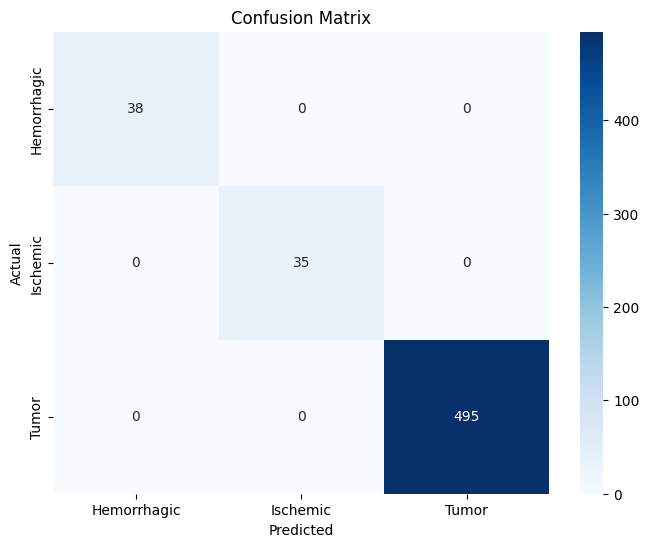

In [11]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def evaluate_performance(model, val_loader):
    model.eval()
    all_preds = []
    all_labels = []
    
    # 1. Get Predictions
    print("Generating predictions for Evaluation...")
    with torch.no_grad():
        for images, labels, _ in tqdm(val_loader, desc="Evaluating"):
            images = images.to(DEVICE)
            class_logits, _ = model(images)
            _, preds = torch.max(class_logits, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    # 2. Print Classification Report
    class_names = ["Hemorrhagic", "Ischemic", "Tumor"]
    print("\n" + "="*60)
    print("FINAL CLASSIFICATION REPORT")
    print("="*60)
    print(classification_report(all_labels, all_preds, target_names=class_names))
    
    # 3. Plot Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

# --- THE FIX IS HERE ---
# 1. Re-generate the file lists (using the helper function from training)
train_files, val_files = create_safe_splits(DATA_DIR)

# 2. Load the concept data dictionary
labeled_data = {}
if os.path.exists(LABELED_CSV):
    df = pd.read_csv(LABELED_CSV)
    for _, row in df.iterrows():
        concepts = torch.tensor([
            row['has_hyperdensity'], row['has_hypodensity'], 
            row['has_mass_effect'], row['has_midline_shift']
        ], dtype=torch.float32)
        labeled_data[row['filename']] = concepts

# 3. Define Transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# 4. Create the Validation Dataset & Loader correctly
val_set = SafeHybridDataset(val_files, labeled_data, transform=transform)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)

# Run Evaluation
evaluate_performance(model, val_loader)

d:\Gam3a\Senior2\Neuroengineer\project\.venv\Lib\site-packages\torch\nn\modules\module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
d:\Gam3a\Senior2\Neuroengineer\project\.venv\Lib\site-packages\torch\nn\modules\module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
d:\Gam3a\Senior2\Neuroengineer\project\.venv\Lib\site-packages\torch\nn\modules\module.py:1866: FutureWarning: Using a non-full backward hook when the

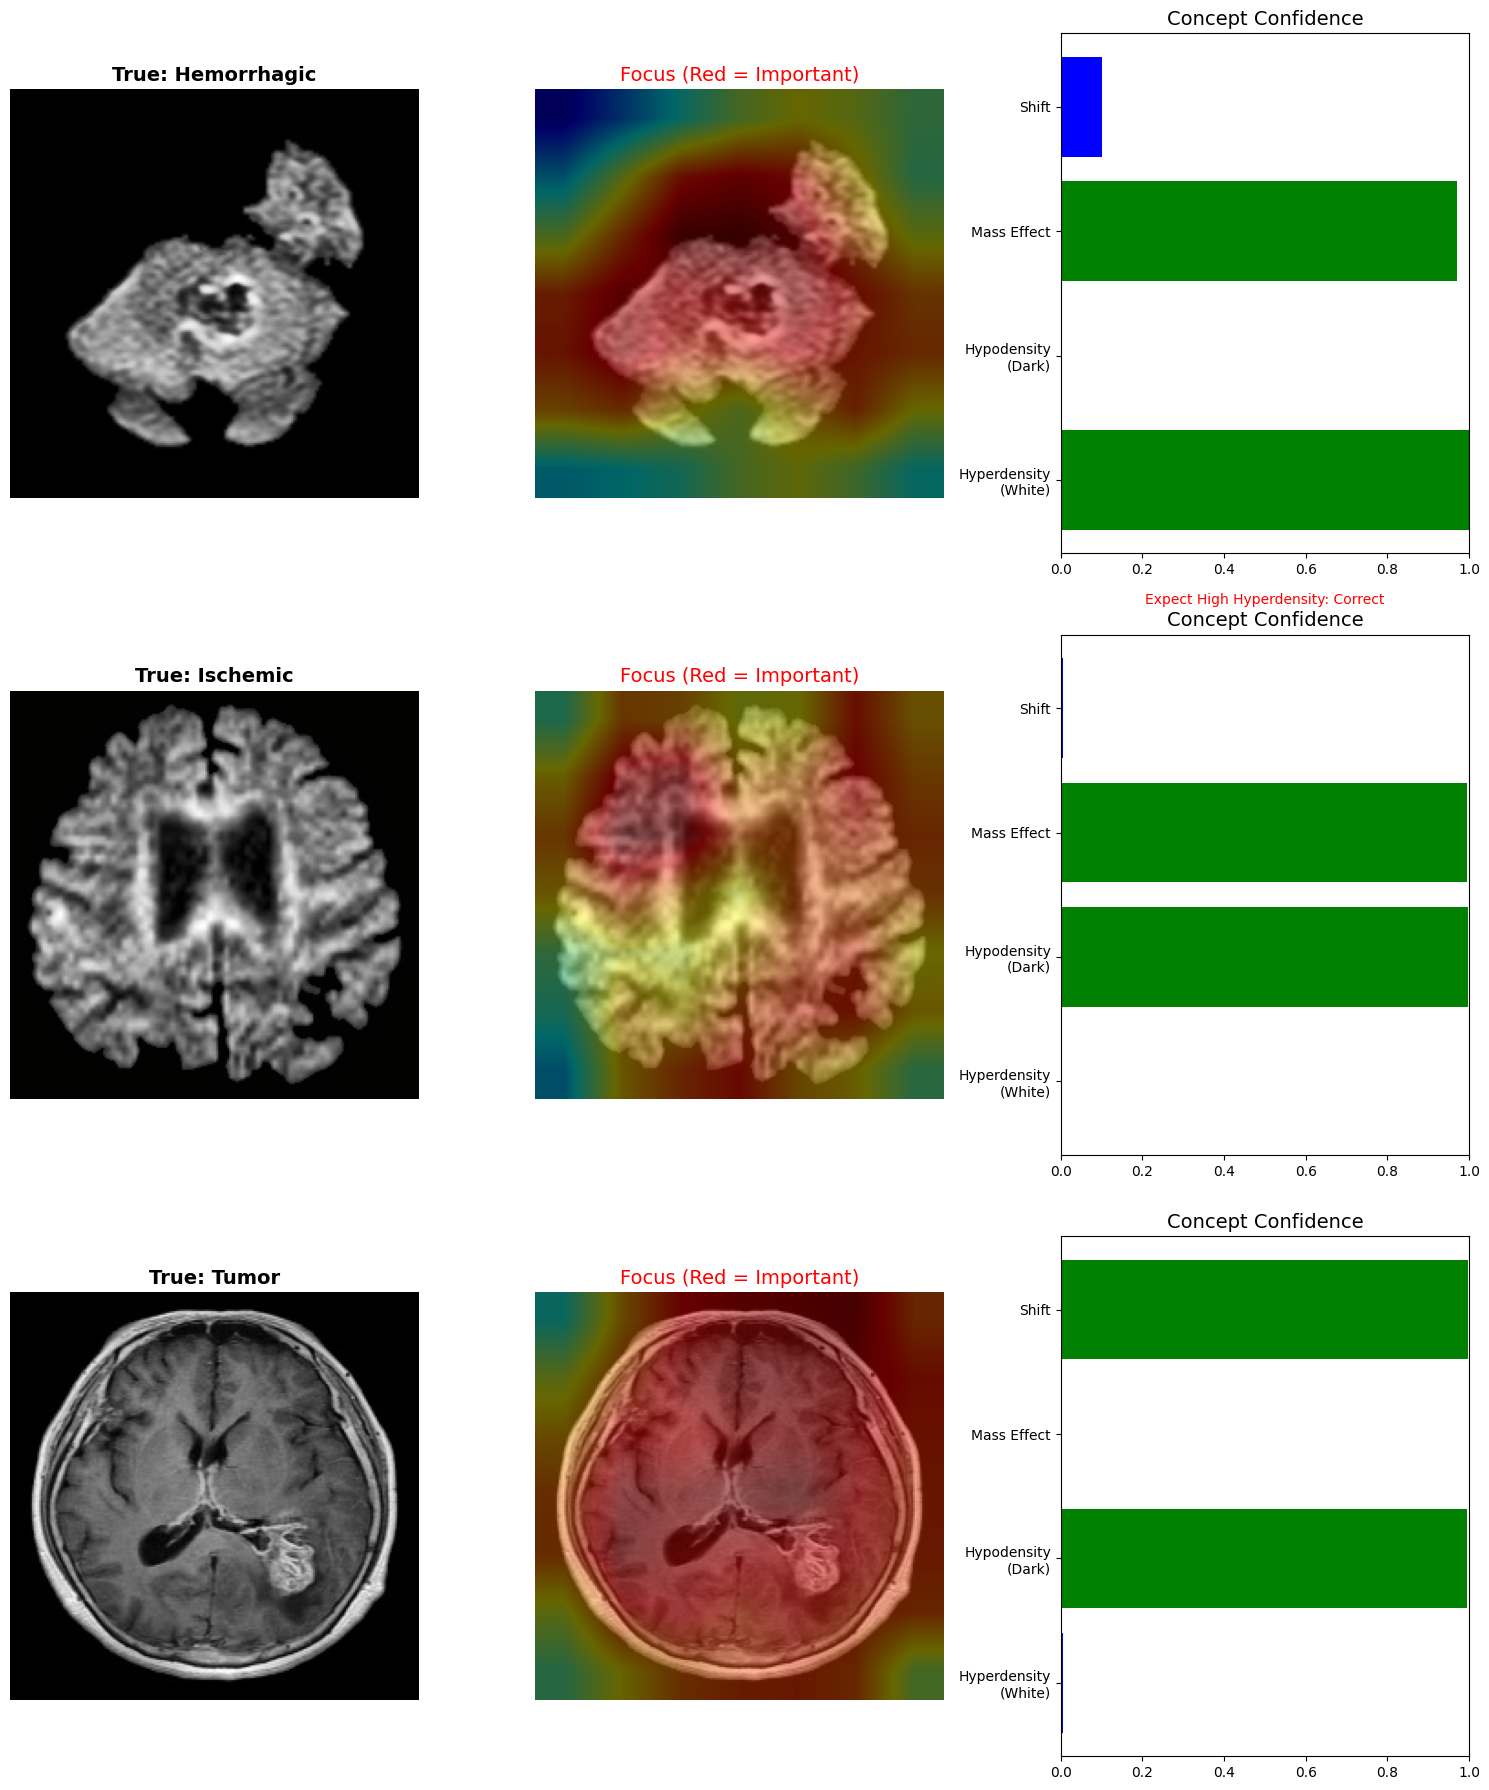

In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        
        # Hook for gradients
        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def __call__(self, x, class_idx=None):
        # 1. Forward Pass
        self.model.zero_grad()
        class_logits, _ = self.model(x)
        
        if class_idx is None:
            class_idx = torch.argmax(class_logits)
            
        # 2. Backward Pass (Targeting the predicted class score)
        score = class_logits[0, class_idx]
        score.backward()
        
        # 3. Generate Map
        # Pool gradients across channels
        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])
        
        # Weight the activations by gradients
        activations = self.activations[0]
        for i in range(activations.shape[0]):
            activations[i, :, :] *= pooled_gradients[i]
            
        # Average the channels to get the heatmap
        heatmap = torch.mean(activations, dim=0).cpu().detach().numpy()
        
        # ReLU (Keep only positive influence)
        heatmap = np.maximum(heatmap, 0)
        
        # Normalize
        if np.max(heatmap) != 0:
            heatmap /= np.max(heatmap)
            
        return heatmap, class_idx.item()

def visualize_gradcam_final(model, dataset, num_samples=3):
    model.eval()
    target_layer = model.backbone[-2] 
    grad_cam = GradCAM(model, target_layer)
    
    class_names = ["Hemorrhagic", "Ischemic", "Tumor"]
    
    # Select specific samples to test "Cheating"
    # We want 1 of each class
    indices = []
    found_classes = set()
    
    # Scan dataset to find one of each
    for i in range(len(dataset)):
        _, label, _ = dataset[i]
        if label not in found_classes:
            indices.append(i)
            found_classes.add(label)
        if len(found_classes) == 3:
            break
            
    plt.figure(figsize=(15, 6 * len(indices)))
    
    for i, idx in enumerate(indices):
        image_tensor, label_idx, concepts = dataset[idx]
        input_tensor = image_tensor.unsqueeze(0).to(DEVICE)
        
        # 1. Run Grad-CAM
        heatmap, pred_idx = grad_cam(input_tensor)
        
        # 2. Get Concept Scores
        with torch.no_grad():
            _, concept_probs = model(input_tensor)
        c_scores = concept_probs.cpu().numpy()[0]
        
        # 3. Prepare Image for Display
        img_disp = image_tensor.permute(1, 2, 0).numpy()
        img_disp = img_disp * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img_disp = np.clip(img_disp, 0, 1)
        
        # 4. Overlay
        heatmap_resized = cv2.resize(heatmap, (224, 224))
        heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
        heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB) / 255.0
        superimposed = 0.6 * img_disp + 0.4 * heatmap_colored
        
        # PLOT
        # Column 1: Original
        ax1 = plt.subplot(3, 3, i*3 + 1)
        ax1.imshow(img_disp)
        ax1.set_title(f"True: {class_names[label_idx]}", fontsize=14, fontweight='bold')
        ax1.axis('off')
        
        # Column 2: Explanation (Heatmap)
        ax2 = plt.subplot(3, 3, i*3 + 2)
        ax2.imshow(superimposed)
        ax2.set_title(f"Focus (Red = Important)", fontsize=14, color='red')
        ax2.axis('off')
        
        # Column 3: Concept Logic
        ax3 = plt.subplot(3, 3, i*3 + 3)
        concept_names = ["Hyperdensity\n(White)", "Hypodensity\n(Dark)", "Mass Effect", "Shift"]
        colors = ['blue' if s < 0.5 else 'green' for s in c_scores]
        ax3.barh(np.arange(4), c_scores, color=colors)
        ax3.set_yticks(np.arange(4))
        ax3.set_yticklabels(concept_names)
        ax3.set_xlim(0, 1)
        ax3.set_title(f"Concept Confidence", fontsize=14)
        
        # Add Text Verdict
        if label_idx == 0: # Hemorrhagic
            verdict = "Correct" if c_scores[0] > 0.5 else "Confused"
            ax3.text(0.5, -1, f"Expect High Hyperdensity: {verdict}", ha='center', color='red')

    plt.tight_layout()
    plt.show()

visualize_gradcam_final(model, val_set)